# Réalisez une veille technique : 
*Notebook Mission 2 - Réalisez une veille technique*

**Classification superviée d’images via les Visions Transformers (ViT)**

Il s'agit de réaliser un POC qui met en oeuvre cette nouvelle technique avec les données image déjà exploitées dans le cadre du projet 6.

In [1]:
# fonctions personnelles pour le pré traitement des données textuelles
import pre_treatment_text as ptt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

import os
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy
from torch.optim.lr_scheduler import OneCycleLR

import transformers
from transformers import ViTFeatureExtractor, ViTForImageClassification, AutoFeatureExtractor
from transformers import TrainingArguments, Trainer

from tqdm import tqdm

from datasets import Dataset 
import evaluate

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("torch version", torch.__version__)
#print("scipy version", scipy.__version__)
#print("statsmodels version", statsmodels.__version__)

print("sklearn version", sklearn.__version__)
print("transformers version", transformers.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
torch version 2.6.0+cpu
sklearn version 1.6.1
transformers version 4.48.1


## 1 - Préparation des données

In [2]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", \
                   sep=',', low_memory=False)
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [3]:
# Transformer l'arbre des catégories en 7 catégories principales
y = data['product_category_tree'].apply(lambda x: ptt.clean_category_first_level(x))
data['category'] = y

In [4]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing


**Créons les dossiers train, val, test qui contiennent les images**

In [25]:
# Définir les dossiers contenant les images
source_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/Images/"  # Dossier où se trouvent les images
train_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category"  
val_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_val"
test_folder = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category_test" 

# Séparer les données (80% train + validation, 30% test)
df_train_val, df_test = train_test_split(data, test_size=0.20, stratify=data['category'], random_state=42)

# Séparer les données (80% train + 20% validation)
df_train, df_val = train_test_split(df_train_val, test_size=0.20, stratify=df_train_val['category'], random_state=42)

def copy_images(df_subset, destination_folder):
    """ Fonction pour copier les images dans le dossier approprié. """
    for _, row in df_subset.iterrows():
        image_name = row['image']
        category = row['category']

        # Chemin source et destination
        src_path = os.path.join(source_folder, image_name)
        dest_folder = os.path.join(destination_folder, category)
        dest_path = os.path.join(dest_folder, image_name)

        # Créer le dossier s'il n'existe pas
        os.makedirs(dest_folder, exist_ok=True)

        # Vérifier si l'image existe avant de la copier
        if os.path.exists(src_path):
            shutil.copy2(src_path, dest_path)  # Copie sans supprimer l'original
            print(f"✅ {image_name} copié dans {dest_folder}")
        else:
            print(f"⚠️ Image non trouvée : {image_name}")

# Copier les images dans les dossiers appropriés
print("📂 Copie des images d'entraînement...")
copy_images(df_train, train_folder)

print("📂 Copie des images de validation...")
copy_images(df_val, val_folder)

print("📂 Copie des images de test...")
copy_images(df_test, test_folder)

print("✅ Opération terminée !")

📂 Copie des images d'entraînement...
✅ 762b6b22cccf91935e92446efe298fe3.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Baby Care
✅ fc93a41f31c4e997fbfcc5bd0a63ee65.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Watches
✅ 503bb08f7bdf6a395ec564dd1dc83619.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Kitchen  Dining
✅ e4922f01eda047582cd72e9d1063ab7a.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Decor  Festive Needs
✅ cc2acb156df3202f172b280132ab459a.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Home Furnishing
✅ d98147c96d2eebf723b2b67d791bcdaa.jpg copié dans C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart/images_per_category\Watches
✅ b91b13aceec0a140944a2c8915e45e59.jpg copié dans C:/Users/admin/Documents/Projet

**Créons les datasets "images" train, validation, et test**

- Augmentation des données avec plusieurs techniques (recadrage aléatoire, retournement horizontal, rotation, variation couleurs...
- Création des jeux de données dans 3 datasets : train, validation, test

In [5]:
# Define dataset paths
data_dir = "C:/Users/admin/Documents/Projets/Projet_6/data_projet/Flipkart"

# Define transformations for data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and data loaders
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "images_per_category"), transform=train_transform)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "images_per_category_val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "images_per_category_test"), transform=val_test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 2 - Vision transformers

Tout comme les modèles basés sur les transformateurs ont révolutionné le NLP, nous assistons maintenant à une explosion d’articles les appliquant à toutes sortes d’autres domaines. L’un des plus révolutionnaires d’entre eux était le Vision Transformer (ViT), qui a été introduit en juin 2021 par une équipe de chercheurs de Google Brain.
Cet article a exploré comment vous pouvez tokeniser des images, tout comme vous le feriez pour des phrases, afin qu’elles puissent être transmises à des modèles de transformateur pour l’entraînement. C’est un concept assez simple, vraiment...

- Fractionner une image en une grille de patchs de sous-images
- Intégrez chaque patch avec une projection linéaire
- Chaque patch incorporé devient un jeton, et la séquence résultante de correctifs incorporés est la séquence que vous transmettez au modèle.

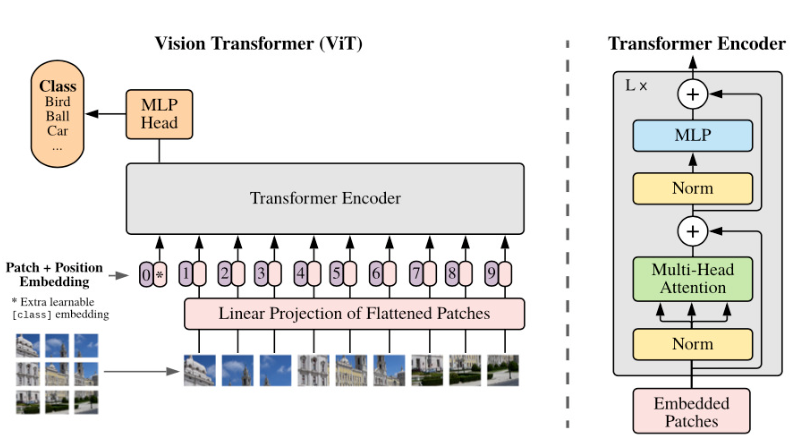



## 3 - Classifier les images

**Méthode non optimisée inspirée du Kernel https://www.kaggle.com/code/adhoppin/testing-vit-for-image-classification/notebook :**

- Initaliser un extracteur de features
- Charger le modèle ViT pré-entraîné en indiquant les 7 catégories
- Définir la fonction de perte
- Définir l'optimiseur sur AdamW avec un taux d'apprentissage de 0.0001
- Création d'un shceduler pour ajuster le taux d'apprentissage pendant l'entraînement (max  = 0.001)
- Entraîner le modèle sur 20 epochs
- Calculer l'accuracy et la fonction de perte, et sauvegarder le meilleur modèle à la fin de chaque epochs
- Evaluer le meilleur modèle avec le jeu de test

In [32]:
# Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # Adjust learning rate

# Learning rate scheduler with warm-up
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=len(train_loader) * 20)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_validation_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        validation_accuracy = 100 * correct / total
        
        # Save the model if validation accuracy improved
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            torch.save(model.state_dict(), "best_model.pth")
    
    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Loss: {running_loss / len(train_loader):.4f} "
          f"Validation Accuracy: {validation_accuracy:.2f}%")
    
    # Adjust learning rate
    scheduler.step()

# Load the best model for testing
model.load_state_dict(torch.load("best_model.pth"))

# Testing the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

C:\Users\admin\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\admin\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/20] Loss: 1.8610 Validation Accuracy: 65.48%
Epoch [2/20] Loss: 1.6300 Validation Accuracy: 77.38%
Epoch [3/20] Loss: 1.3646 Validation Accuracy: 82.14%
Epoch [4/20] Loss: 1.1176 Validation Accuracy: 80.95%
Epoch [5/20] Loss: 0.9079 Validation Accuracy: 82.74%
Epoch [6/20] Loss: 0.7553 Validation Accuracy: 82.74%
Epoch [7/20] Loss: 0.6386 Validation Accuracy: 84.52%
Epoch [8/20] Loss: 0.5346 Validation Accuracy: 83.33%
Epoch [9/20] Loss: 0.4667 Validation Accuracy: 82.14%
Epoch [10/20] Loss: 0.4218 Validation Accuracy: 84.52%
Epoch [11/20] Loss: 0.3505 Validation Accuracy: 81.55%
Epoch [12/20] Loss: 0.3519 Validation Accuracy: 85.12%
Epoch [13/20] Loss: 0.2586 Validation Accuracy: 86.31%
Epoch [14/20] Loss: 0.2620 Validation Accuracy: 85.71%
Epoch [15/20] Loss: 0.2420 Validation Accuracy: 84.52%
Epoch [16/20] Loss: 0.2057 Validation Accuracy: 85.12%
Epoch [17/20] Loss: 0.2524 Validation Accuracy: 79.17%
Epoch [18/20] Loss: 0.2297 Validation Accuracy: 82.74%
Epoch [19/20] Loss:

Le score obtenu est meilleur que celui évalué dans le projet 6 avec CNN Transfert Learning :
- Validation : 86.31 % (78% dans le projet 6) avec une fonction de perte 0.2262
- Test : 81.90 % (0.78% dans le projet 6)

Par le traitement a été très long. Près de 6 heures sur mon PC en mode CPU. Voyons si on peut réduire le temps de traitement sans trop dégrader la qualité du résultat.

## 4 - Classifier les images : méthode optimisée

Je suis parti cette fois du fine tuning décrit sur le site d'Hugging Face : https://huggingface.co/blog/fine-tune-vit

Paramètres du modèle :

output_dir="./results"	Dossier où seront enregistrés les checkpoints du modèle entraîné et les logs.
evaluation_strategy="epoch"	Définit quand évaluer le modèle sur les données de validation. Ici, c'est à chaque époque.
save_strategy="epoch"	Sauvegarde les checkpoints du modèle à chaque époque.
learning_rate=2e-5	Taux d'apprentissage (learning rate), ici 0.00002.
per_device_train_batch_size=16	Taille du batch pour l'entraînement sur chaque GPU ou CPU.
per_device_eval_batch_size=16	Taille du batch pour l'évaluation.
num_train_epochs=10	Nombre total d'époques pour l'entraînement (le modèle passera 10 fois sur l'ensemble des données d'entraînement).
weight_decay=0.01	Pénalité pour éviter le surapprentissage (régularisation L2).
logging_dir="./logs"	Dossier où seront stockés les logs de l'entraînement (utile pour TensorBoard).
logging_steps=10	Fréquence d'affichage des logs pendant l'entraînement (toutes les 10 itérations).
save_total_limit=2	Garde uniquement les 2 derniers checkpoints, pour économiser de l'espace disque.
load_best_model_at_end=True	Charge automatiquement le meilleur modèle (basé sur metric_for_best_model) à la fin de l'entraînement.
metric_for_best_model="accuracy"	Utilise la métrique "accuracy" pour déterminer le meilleur modèle (peut être modifié selon ton cas : ex. f1, loss).

In [9]:
# Création des DataLoaders (optionnel, pour visualiser les données)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Chargement du Feature Extractor de Hugging Face
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Préparation des données pour le Trainer de Hugging Face
def transform_images(examples):
    print(f"Type de examples['image'] : {type(examples['image'])}")
    print(f"Taille de examples['image'] : {len(examples['image'])}")
    print(f"Type du premier élément : {type(examples['image'][0])}")

    # Prétraiter les images et s'assurer qu'elles sont dans le bon format
    processed_images = []
    for img in examples["image"]:
        if isinstance(img, list):  # Si l'image est encore une liste imbriquée
            img = np.array(img)  # Convertir en tableau NumPy

        # Vérifier les valeurs de l'image et normaliser si nécessaire
        img = np.clip(img, 0, 255)  # Clipper les valeurs entre 0 et 255
        img = img / 255.0  # Normaliser les valeurs entre 0 et 1

        processed_images.append(img)

    print(f"Taille après prétraitement : {len(processed_images)}")
    print(f"Type du premier élément après prétraitement : {type(processed_images[0])}")

    # Appliquer le feature_extractor
    images = feature_extractor(images=processed_images, return_tensors="pt")["pixel_values"]
    labels = torch.tensor(examples["label"])

    return {"pixel_values": images, "labels": labels}

train_data = Dataset.from_dict({"image": [x[0] for x in train_dataset], "label": [x[1] for x in train_dataset]})
val_data = Dataset.from_dict({"image": [x[0] for x in valid_dataset], "label": [x[1] for x in valid_dataset]})

train_data = train_data.map(transform_images, batched=True)
val_data = val_data.map(transform_images, batched=True)

# Chargement du modèle ViT pré-entraîné
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(train_dataset.classes)
)

# Définition des métriques pour l'entraînement
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Définition des arguments d'entraînement (comme sur Hugging Face)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Création du Trainer Hugging Face
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics
)

# Entraînement du modèle
trainer.train()

# Évaluation sur le test set
test_data = Dataset.from_dict({"image": [x[0] for x in test_dataset], "label": [x[1] for x in test_dataset]})
test_data = test_data.map(transform_images, batched=True)

results = trainer.evaluate(test_data)
print("📊 Test Accuracy:", results["eval_accuracy"])

# Tracer les courbes de loss et accuracy
logs = trainer.state.log_history

train_losses = [log["loss"] for log in logs if "loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]
eval_accuracies = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]

plt.figure(figsize=(12, 5))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(eval_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()

plt.show()

C:\Users\admin\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Type de examples['image'] : <class 'list'>
Taille de examples['image'] : 672
Type du premier élément : <class 'list'>
Taille après prétraitement : 672
Type du premier élément après prétraitement : <class 'numpy.ndarray'>


Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Type de examples['image'] : <class 'list'>
Taille de examples['image'] : 168
Type du premier élément : <class 'list'>
Taille après prétraitement : 168
Type du premier élément après prétraitement : <class 'numpy.ndarray'>


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\admin\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
2025/04/04 14:50:44 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id 4832aa3552164c3cb69f2759ff8e6b85: Failed to log run data: Exception: Changing param values is not allowed. Param with key='per_device_train_batch_size' was already logged with value='16' for run ID='4832aa3552164c3cb69f2759ff8e6b85'. Attempted logging new value '32'.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.966200,1.965883,0.142857


KeyboardInterrupt: 